<h1>Optimization Project</h1>
**Author:** Yehonatan Zolti  
**Date:** 07-05-2025  

**What we’ll do:**  
1. Set up constants & helper functions  
2. Define the time‐dependent Hamiltonian  
3. Run CMA optimizations for various protocols  
4. Visualize fidelity and infidelity maps  
5. Compare pulse shapes and final Bloch states  


## 📑 Table of Contents  
- [1. Imports & Global Style](#imports)  
- [2. Global Constants](#globals)  
- [3. Helper Functions](#helpers)  
- [4. Hamiltonian & Solver](#hamiltonian)  
- [5. Optimization Setup](#optimization)  
- [6. Precompute & Grids](#precompute)  
- [7. Fidelity vs Time](#fidelity)  
- [8. Infidelity Maps (T₁/T₂)](#inf-t1-t2)  
- [9. Infidelity Maps (Area vs Doppler)](#inf-area-doppler)  
- [10. Pulse Envelopes & Bloch Spheres](#pulses-bloch)  
- [11. Conclusions & Next Steps](#conclusion)  


<h2 id="imports">1. Imports &amp; Global Style</h2>
Here we load all Python packages, enable `%matplotlib inline`, and set a consistent plotting style.  


In [1]:
import json, time, inspect, os
from pathlib import Path
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors as mcolors
import qutip as qx
import nevergrad as ng
import matplotlib.animation as animation
from IPython.display import HTML
from qutip import Bloch
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
from tqdm import tqdm

%matplotlib inline

In [2]:
plt.rcParams.update({
    'figure.dpi': 300,
    'font.size': 10,
    'axes.labelsize': 10,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 9,
    'lines.linewidth': 2,
})

COL = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','darkviolet']
cm = 1/2.54

figs_dir = r"/home/yehon/projects/grape-crab-qoc/results/results/CMA-ES"
os.makedirs(figs_dir, exist_ok=True)



### Save optimized pulses, detunings, all open figures, and a manifest

In [36]:
def save_run(omega_dict, delta_dict, *, seed=None, algo_settings=None, run_root="results"):
    """
    Save every Ω(t)/Δ(t) array plus every open Matplotlib figure
    into a date‑stamped sub‑folder of `run_root`.

    Parameters
    ----------
    omega_dict : dict[str, np.ndarray]
        Keys = protocol names (e.g. 'original', 'fidelity', …),
        values = optimized Rabi‑pulse arrays.
    delta_dict : dict[str, np.ndarray]
        Keys = protocol names, values = optimized detuning arrays.
    seed : int | None
        PRNG seed used for the optimizations (for provenance).
    algo_settings : dict | None
        Any other metadata you want recorded (BUDGET, target fidelity, …).
    run_root : str | Path
        Top‑level directory under which the date‑stamped folder is created.
    """
    # 1) make run directory
    # ts   = datetime.now().strftime("%Y‑%m‑%d_%H‑%M‑%S")
    ts   = "CMA-ES"
    rdir = Path(run_root) / ts
    rdir.mkdir(parents=True, exist_ok=True)

    # 2) save pulses & detunings (one .npy per protocol)
    for key, arr in omega_dict.items():
        np.save(rdir / f"Omega_{key}.npy", arr)
    for key, arr in delta_dict.items():
        np.save(rdir / f"Delta_{key}.npy", arr)

    # 3) save every active figure as PNG + PDF
    for i, num in enumerate(plt.get_fignums(), start=1):
        fig = plt.figure(num)
        fig.savefig(rdir / f"fig_{i:02d}.pdf", bbox_inches="tight")

    # 4) write a JSON manifest for provenance
    meta = {
        "timestamp"   : ts,
        "notebook"    : os.path.basename(inspect.getfile(save_run)),
        "protocols"   : list(omega_dict.keys()),
        "seed"        : seed,
        "algo_settings": algo_settings or {},
        "n_figures"   : len(plt.get_fignums()),
    }
    with open(rdir / "run_manifest.json", "w") as f:
        json.dump(meta, f, indent=2)

    # 5) console summary
    print(f"\n✅ Saved pulses, detunings, {meta['n_figures']} figures, and "
          f"a manifest to:\n   {rdir.resolve()}\n")


<h2 id="globals">2. Global Constants</h2>

Define simulation parameters like `tau`, `Nt`, and any physical constants. These are used throughout every cell.  


In [4]:
tau, Nt = 0.05, 50
tlist = np.linspace(-tau, tau, Nt)

# noise times (µs)
T1, T2 = 400.0, 100.0
Tphi = 1 / (1 / T2 - 1 / (2 * T1))

# basis & target
zro, one = qx.basis(2, 0), qx.basis(2, 1)
rho_0, rho_t = zro * zro.dag(), one * one.dag()

# optimisation settings
AREA_TARGET = 4 * np.pi
LAMBDA_PEN  = 1.0
N_MODES     = 5        # Fourier terms
rng = np.random.default_rng(3)  # reproducibility

<a id="helpers"></a>
## 3. Helper Functions  
Encapsulate recurring tasks (e.g., building the Hamiltonian, computing fidelity). Keeping these here makes the main flow clean.  


In [5]:
def smooth(t):
    return np.sin(np.pi * (t + tau) / (2 * tau)) ** 2


def fourier(t, coeff):
    t_arr = np.asarray(t)
    n = np.arange(1, len(coeff) + 1)[:, None]
    series = (coeff[:, None] *
              np.sin(n * np.pi * (t_arr + tau) / (2 * tau))).sum(0)
    val = smooth(t_arr) * series
    if np.size(val) == 1:          # works for 0‑D or 1‑element 1‑D
        return float(val.ravel()[0])
    return val



# base analytic pulses
omega_base = lambda t, A, B, C: (A - B * (t / tau) ** 4 + C * (t / tau) ** 6) * smooth(t)
delta_base = lambda t, a, b: a * (t / tau) - b * (t / tau) ** 3


def pulses(t, p):
    Ω = omega_base(t, p['A'], p['B'], p['C']) + fourier(t, p['corr'])
    Δ = delta_base(t, p['a'], p['b']) + fourier(t, p['dcorr'])
    return Ω, Δ


def pulse_area(p):
    Ω = np.array([pulses(t, p)[0] for t in tlist])
    return np.trapz(Ω, tlist)

<a id="hamiltonian"></a>
## 4. Hamiltonian & Solver  
Construct the time-dependent Hamiltonian and set up the QuTiP solver. This cell returns a function you’ll call for each protocol.  


In [6]:
def H_td(p):
    return [
        [qx.sigmax(), lambda t, par=p: pulses(t, par)[0]],
        [qx.sigmaz(), lambda t, par=p: pulses(t, par)[1]],
    ]

def build_cops(T1_val, T2_val):
    denom = 1 / T2_val - 1 / (2 * T1_val)
    if denom <= 0:
        raise ValueError("Unphysical T1/T2 combination")
    Tphi_val = 1 / denom
    return [
        np.sqrt(1 / T1_val) * qx.destroy(2),
        np.sqrt(1 / (2 * Tphi_val)) * qx.sigmaz(),
    ]

c_ops0 = build_cops(T1, T2)

def solve(p, c_ops):
    return qx.mesolve(H_td(p), rho_0, tlist, c_ops, e_ops=[]).states

def inst_ground(t, p):
    Ω, Δ = pulses(t, p)
    H = Ω * qx.sigmax() + Δ * qx.sigmaz()
    vals, vecs = H.eigenstates()
    return vecs[int(np.argmin(vals))]

In [ ]:
# ── Determinism setup ──────────────────────────────────────────────────────────
SEED   = 42          # pick once, reuse everywhere
BUDGET = 2000
np.random.seed(SEED)
# ── Your grids and BASE dict ─────────────────────────────────────────────────
scale_vals   = np.linspace(0.5, 1.0, 5)
doppler_vals = np.linspace(-10, 10, 5)

BASE = {
    'A': 1.0, 'B': 3.0, 'C': 2.0,
    'a': 1.25, 'b': 0.25,
    'corr':  np.zeros(N_MODES),
    'dcorr': np.zeros(N_MODES),
}
print(np.trapezoid([pulses(t, BASE)[0] for t in tlist], tlist))

0.04562833927461403


/tmp/ipykernel_946130/3906846596.py:15: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  print(np.trapz([pulses(t, BASE)[0] for t in tlist], tlist))


<a id="optimization"></a>
## 5. Optimization Setup  
Configure Nevergrad’s CMA optimizer and define the cost functions for “Fidelity”, “Adiabatic”, and “Noise Avg”.  


In [8]:
# ── Determinism setup ──────────────────────────────────────────────────────────
SEED   = 42          # pick once, reuse everywhere
BUDGET = 2000
np.random.seed(SEED)
# ── Your grids and BASE dict ─────────────────────────────────────────────────
scale_vals   = np.linspace(0.5, 1.0, 5)
doppler_vals = np.linspace(-10, 10, 5)

BASE = {
    'A': 1.0, 'B': 3.0, 'C': 2.0,
    'a': 1.25, 'b': 0.25,
    'corr':  np.zeros(N_MODES),
    'dcorr': np.zeros(N_MODES),
}
normalization = 4*np.pi / (np.trapezoid([pulses(t, BASE)[0] for t in tlist], tlist))
print(normalization)
BASE = {
    'A': 1.0 * normalization,
    'B': 3.0 * normalization,
    'C': 2.0 * normalization,
    'a': 1.25 * normalization * 0.55,
    'b': 0.25 * normalization * 0.55,
    'corr':  np.zeros(N_MODES),
    'dcorr': np.zeros(N_MODES),
}

TT_grid = np.linspace(1, 50, 5)  # deterministic noise grid

# ── Objective factory (unchanged) ────────────────────────────────────────────
def objective(kind):
    def f(x):
        p = BASE.copy()
        p['corr'], p['dcorr'] = x[:N_MODES], x[N_MODES:]
        st = solve(p, c_ops0)
        fid_err = 1 - qx.fidelity(rho_t, st[-1])
        area_pen = LAMBDA_PEN * max(0, pulse_area(p) - AREA_TARGET) ** 2
        total = fid_err + area_pen

        if kind == 'adia':
            ad = np.mean([1 - qx.fidelity(s, inst_ground(t, p)) for s, t in zip(st, tlist)])
            total += ad

        elif kind == 'noise':
            errs = []
            for T1v in TT_grid:
                for T2v in TT_grid:
                    try:
                        cops = build_cops(T1v, T2v)
                        errs.append(1 - qx.fidelity(
                            rho_t, solve(p, cops)[-1]))
                    except ValueError:
                        continue
            total += np.mean(errs) if errs else 0

        elif kind == 'ensemble':
            errs = []
            for sc in scale_vals:
                for dop in doppler_vals:
                    H_ad = [
                      [qx.sigmax(), lambda t, par=p, s=sc: s * pulses(t, par)[0]],
                      [qx.sigmaz(), lambda t, par=p, d=dop: pulses(t, par)[1] + d],
                    ]
                    final = qx.mesolve(H_ad, rho_0, tlist, c_ops0, e_ops=[]).states[-1]
                    errs.append(1 - qx.fidelity(rho_t, final))
            total += np.mean(errs)

        return total
    return f

def fidelity_err(x):
    p = BASE.copy()
    p['corr'], p['dcorr'] = x[:N_MODES], x[N_MODES:]
    st = solve(p, c_ops0)
    return 1 - qx.fidelity(rho_t, st[-1])

# ── Deterministic CMA runner ─────────────────────────────────────────────────

def run_cma(kind, target_fid=1e-6, BUDGET=BUDGET, seed=SEED):
    # 1) build parametrization and attach a *seeded* RNG
    rng   = np.random.RandomState(seed)
    param = ng.p.Array(shape=(2 * N_MODES,))
    param.random_state = rng            # <— key line

    # 2) create optimizer (inherits the same RNG)
    opt = ng.optimizers.CMA(parametrization=param, budget=BUDGET)

    # 3) normal ask/tell loop
    obj = objective(kind)
    for _ in tqdm(range(BUDGET), desc=f"CMA ({kind})", unit="it"):
        x_param  = opt.ask()
        loss     = obj(x_param.value)
        opt.tell(x_param, loss)
        if loss < target_fid:           # early stop on fidelity term
            tqdm.write(f"Stopped early: fidelity error = {fid_loss:.2e}")
            break

    return opt.recommend().value
# ── Run all four optimizations (deterministically) ────────────────────────────
corr_fid      = run_cma('fid')
corr_adia     = run_cma('adia')
# corr_noise    = run_cma('noise')
corr_ensemble = run_cma('ensemble')

# ── Collect into PROT dict ────────────────────────────────────────────────────
PROT = {
    'Original':  BASE,
    'Fidelity':  {**BASE, 'corr': corr_fid[:N_MODES],      'dcorr': corr_fid[N_MODES:]},
    'Adiabatic': {**BASE, 'corr': corr_adia[:N_MODES],     'dcorr': corr_adia[N_MODES:]},
    # 'Noise':     {**BASE, 'corr': corr_noise[:N_MODES],    'dcorr': corr_noise[N_MODES:]},
    'Ensemble':  {**BASE, 'corr': corr_ensemble[:N_MODES], 'dcorr': corr_ensemble[N_MODES:]}
}


275.407144203266


CMA (fid):   0%|          | 0/2000 [00:00<?, ?it/s]/home/yehon/projects/grape-crab-qoc/.venv/lib/python3.12/site-packages/qutip/core/data/expm.py:139: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  return Dense(scipy.linalg.sqrtm(matrix.as_ndarray()))
/tmp/ipykernel_946130/4081949684.py:30: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(Ω, tlist)
CMA (ensemble): 100%|██████████| 2000/2000 [22:18<00:00,  1.49it/s]


<a id="precompute"></a>
## 6. Precompute & Grids  
Precompute any look-up tables or grids (e.g., values of pulse areas or Doppler shifts) to speed up your infidelity maps.  


In [ ]:
STATE, FID, OMEGA, DELTA = {}, {}, {}, {}

for name, params in PROT.items():
    st = solve(params, c_ops0)
    STATE[name] = st
    FID[name]   = np.array([qx.fidelity(rho_t, s) for s in st])
    Ω = np.array([pulses(t, params)[0] for t in tlist])
    Δ = np.array([pulses(t, params)[1] for t in tlist])
    OMEGA[name], DELTA[name] = Ω, Δ



AttributeError: 'list' object has no attribute 'items'

In [11]:
from joblib import Parallel, delayed
import itertools
import tqdm_joblib


grid_pts = 50
T1_vals  = np.linspace(0.1, 400, grid_pts)
T2_vals  = np.linspace(0.1, 400, grid_pts)

# pre‑allocate results
INF_T = {k: np.empty((grid_pts, grid_pts)) for k in PROT}

def evaluate_point(i, j):
    """Returns a dict {protocol: infidelity} for one (T1,T2) pair."""
    T1v, T2v = T1_vals[j], T2_vals[i]
    try:
        c_ops = build_cops(T1v, T2v)
    except ValueError:                   # e.g., invalid decoherence pair
        return {k: np.nan for k in PROT}, i, j

    out = {}
    for k, p in PROT.items():
        fid = qx.fidelity(rho_t, solve(p, c_ops)[-1])
        out[k] = 1 - fid
    return out, i, j

# ── run in parallel ───────────────────────────────────────────────────────────
results = Parallel(
    n_jobs=-1,        # -1 = use all logical cores
    backend="loky",   # separate processes → no GIL contention
    verbose=10
)(
    delayed(evaluate_point)(i, j)
    for i, j in itertools.product(range(grid_pts), repeat=2)
)

# reshape / fill the global arrays
for res, i, j in results:
    for k in PROT:
        INF_T[k][i, j] = res[k]



/home/yehon/projects/grape-crab-qoc/.venv/lib/python3.12/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.


/home/yehon/projects/grape-crab-qoc/.venv/lib/python3.12/site-packages/qutip/core/data/expm.py:139: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  return Dense(scipy.linalg.sqrtm(matrix.as_ndarray()))
/home/yehon/projects/grape-crab-qoc/.venv/lib/python3.12/site-packages/qutip/core/data/expm.py:139: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  return Dense(scipy.linalg.sqrtm(matrix.as_ndarray()))
/home/yehon/projects/grape-crab-qoc/.venv/lib/python3.12/site-packages/qutip/core/data/expm.py:139: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  return Dense(scipy.linalg.sqrtm(matrix.as_ndarray()))
/home/yehon/projects/grape-crab-qoc/.venv/lib/python3.12/site-packages/qutip/core/data/expm.py:139: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square ro

In [12]:
# grid definitions
area_vals = np.linspace(0.01*4*np.pi, 2*4*np.pi, grid_pts)
dopp_vals = np.linspace(-70, 70, grid_pts)
A_grid, D_grid = np.meshgrid(area_vals, dopp_vals)

# prepare output dict
INF_AD = {k: np.empty_like(A_grid) for k in PROT}

# adjust total for the progress bar: now it's (#protocols × #doppler × #area)
total = len(PROT) * grid_pts * grid_pts
pbar = tqdm(total=total, desc="Infidelity grid")

for k, p in PROT.items():
    # compute normalization once per protocol
    omega  = np.array([pulses(t, p)[0] for t in tlist])
    delta  = np.array([pulses(t, p)[1] for t in tlist])
    normal = 1 / np.trapz(omega, tlist)
    omega  = normal * omega
    for i, dop in enumerate(dopp_vals):
        for j, ar in enumerate(area_vals):
            # build Hamiltonian
            H_ad = [ [ qx.sigmax(), ar * omega ], [ qx.sigmaz(), delta + dop ] ]
            # propagate and record infidelity
            st = qx.mesolve(H_ad, rho_0, tlist, c_ops0, e_ops=[]).states[-1]
            fid = qx.fidelity(rho_t, st)
            INF_AD[k][i, j] = 1 - fid

            pbar.update(1)

pbar.close()

# floor and find max
EPS_AD = 1e-4
for k in INF_AD:
    INF_AD[k] = np.where(INF_AD[k] < EPS_AD, EPS_AD, INF_AD[k])

VMAX_AD = max(np.nanmax(a) for a in INF_AD.values())


Infidelity grid:   0%|          | 0/10000 [00:00<?, ?it/s]/tmp/ipykernel_946130/3634499914.py:17: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  normal = 1 / np.trapz(omega, tlist)
Infidelity grid: 100%|██████████| 10000/10000 [00:30<00:00, 331.94it/s]


<a id="fidelity"></a>
## 7. Fidelity vs Time  
Plot fidelity as a function of protocol duration to compare how quickly each method reaches high performance.  


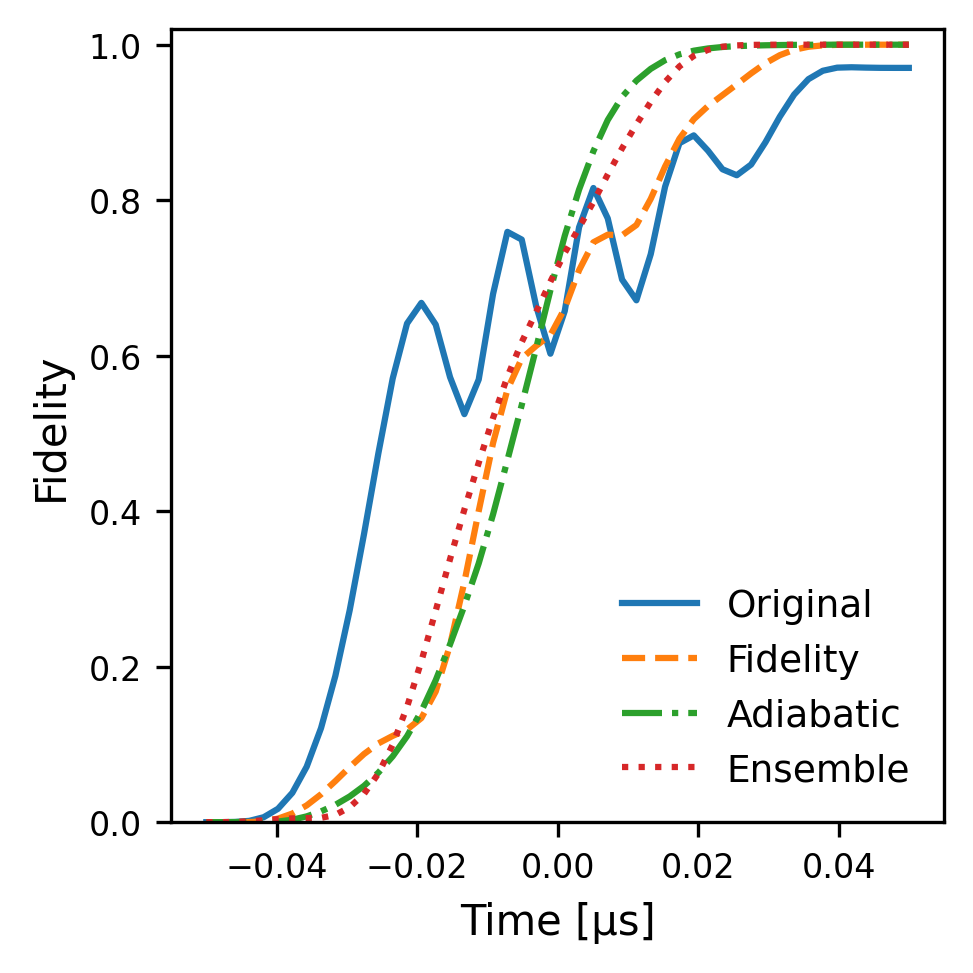

In [13]:

gs = [inst_ground(t, params) for t in tlist]

fig=plt.figure(figsize=(8.5*cm, 8.5*cm))
for idx, k in enumerate(PROT):
    plt.plot(tlist, FID[k], label=k, color=COL[idx], lw=1.5,
             ls=['-', '--', '-.', ':','dotted'][idx])
plt.xlabel('Time [µs]')
plt.ylabel('Fidelity')
plt.ylim(0, 1.02)
plt.legend(frameon=False, ncol=1, loc='lower right')
plt.tight_layout()
filename= f'dynamics.pdf'  
fig.savefig(os.path.join(figs_dir, filename), dpi=300, bbox_inches='tight')
plt.show()

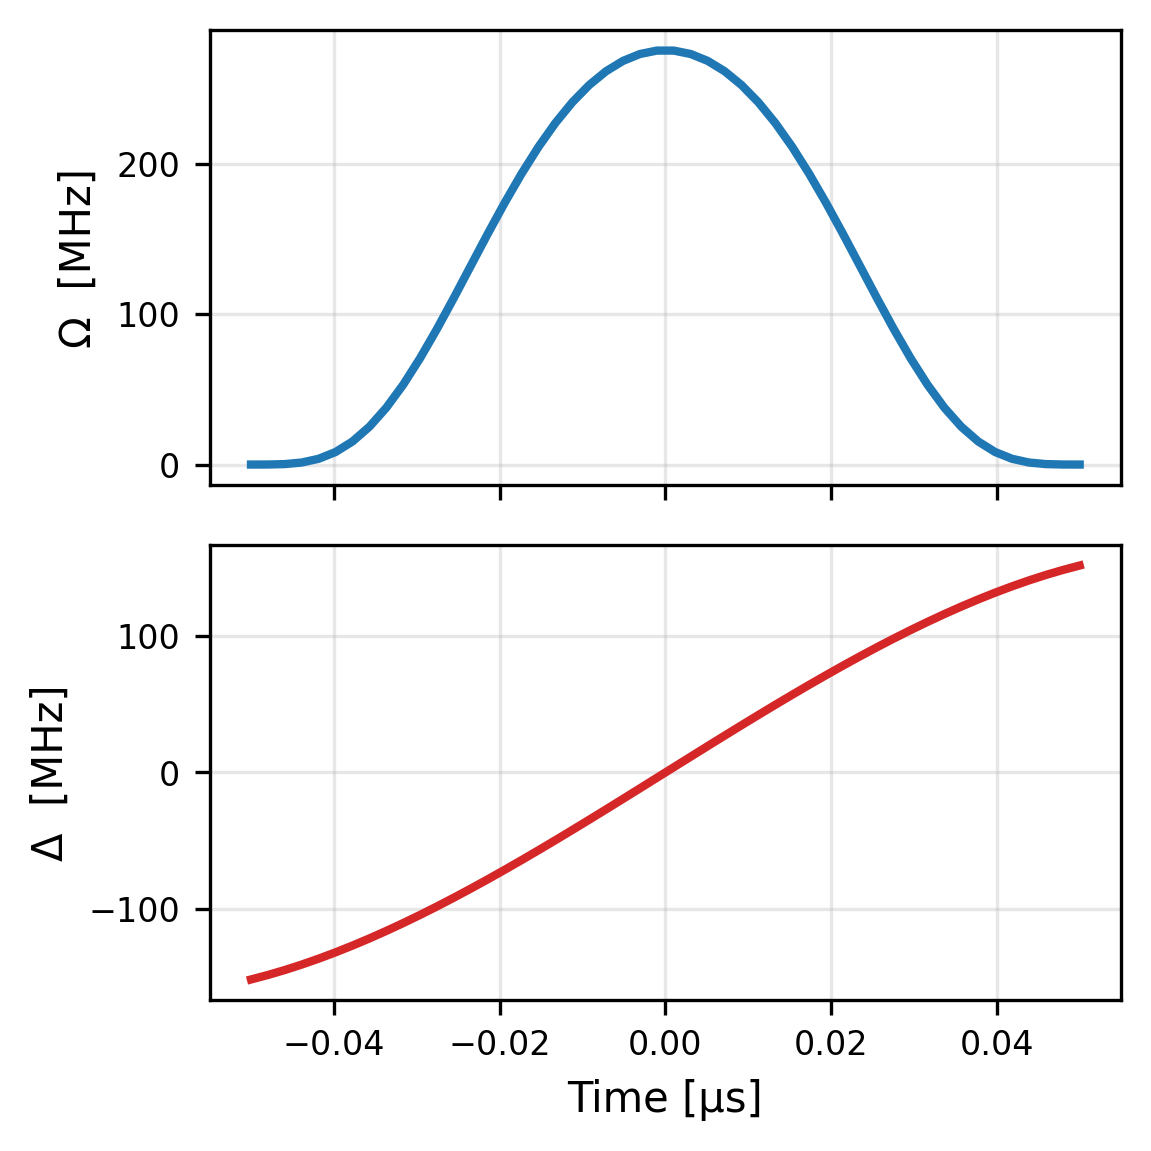

In [15]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10*cm, 10*cm))
area = np.trapezoid(OMEGA['Original'], tlist) / np.pi
ax[0].plot(tlist, OMEGA['Original'], color=COL[0],
ls=['-', '--', '-.', ':', ':'][0],
label=f"{'Original'}  ({area:.2f}π)")
ax[1].plot(tlist, DELTA['Original'], color=COL[3],
ls=['-', '--', '-.', ':', ':'][0])

ax[0].set_ylabel(r'Ω  [MHz]')
ax[1].set_ylabel(r'Δ  [MHz]')
ax[1].set_xlabel('Time [µs]')
for a in ax: a.grid(alpha=0.3)

plt.tight_layout()
filename= f'pulses.pdf'  
fig.savefig(os.path.join(figs_dir, filename), dpi=300, bbox_inches='tight')
plt.show()


/tmp/ipykernel_946130/2711513392.py:4: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(OMEGA[k], tlist) / np.pi


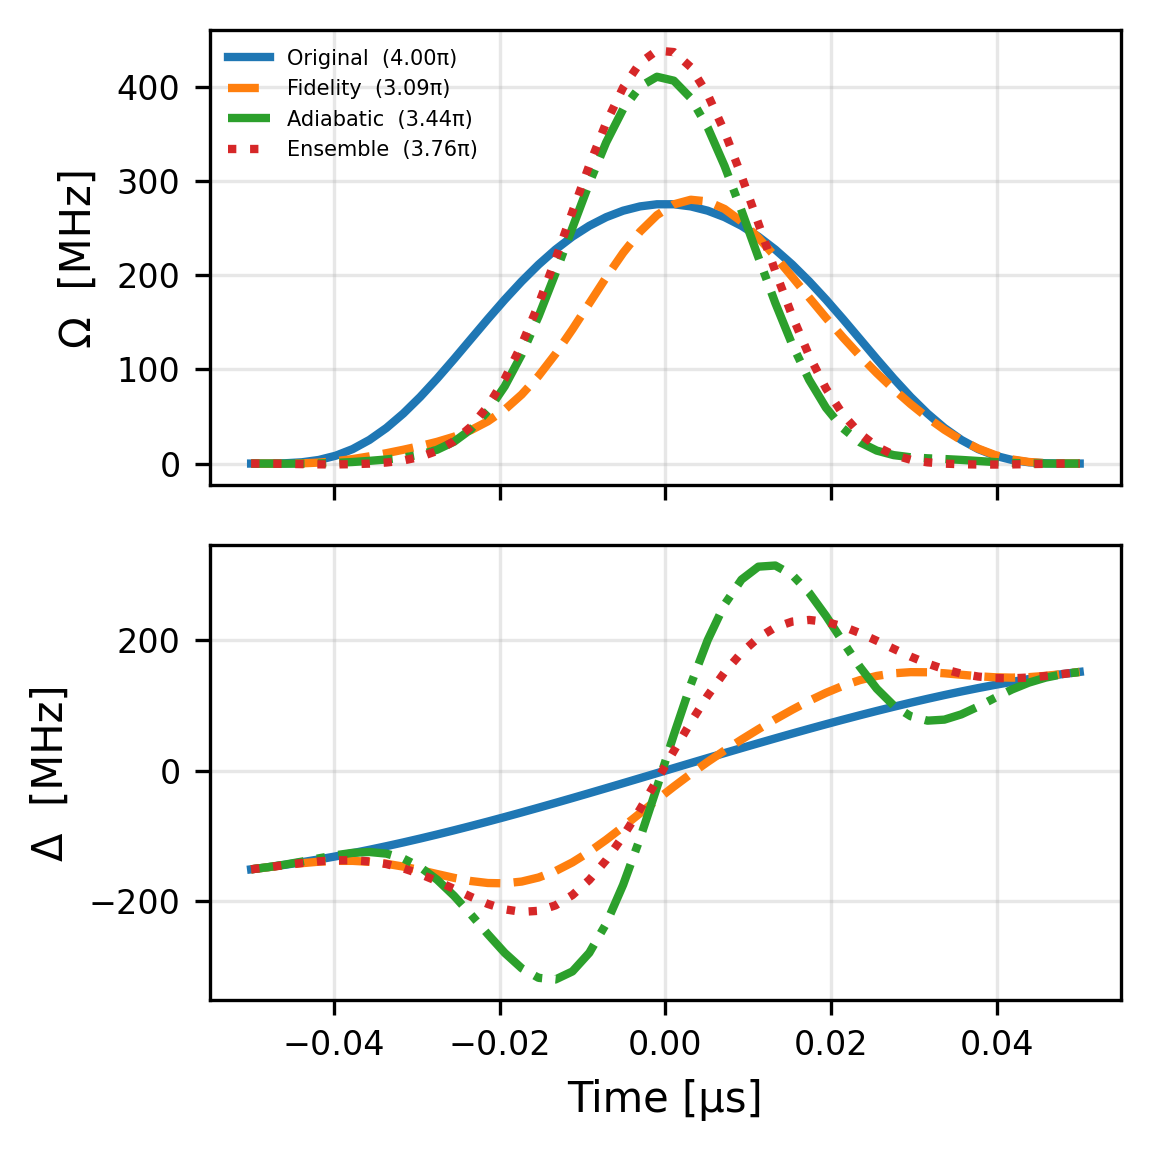

In [16]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10*cm, 10*cm))

for idx, k in enumerate(PROT):
    area = np.trapz(OMEGA[k], tlist) / np.pi
    ax[0].plot(tlist, OMEGA[k], color=COL[idx],
               ls=['-', '--', '-.', ':', ':'][idx],
               label=f"{k}  ({area:.2f}π)")
    ax[1].plot(tlist, DELTA[k], color=COL[idx],
               ls=['-', '--', '-.', ':', ':'][idx])

ax[0].set_ylabel(r'Ω  [MHz]')
ax[1].set_ylabel(r'Δ  [MHz]')
ax[1].set_xlabel('Time [µs]')
ax[0].legend(frameon=False, ncol=1, fontsize=5, loc='upper left')
for a in ax: a.grid(alpha=0.3)

plt.tight_layout()
filename= f'pulses.pdf'  
fig.savefig(os.path.join(figs_dir, filename), dpi=300, bbox_inches='tight')
plt.show()


<a id="inf-t1-t2"></a>
## 8. Infidelity Maps (T₁/T₂)  
Generate heatmaps of infidelity over a range of coherence times T₁ and T₂. Log-scale color map highlights critical regimes.  


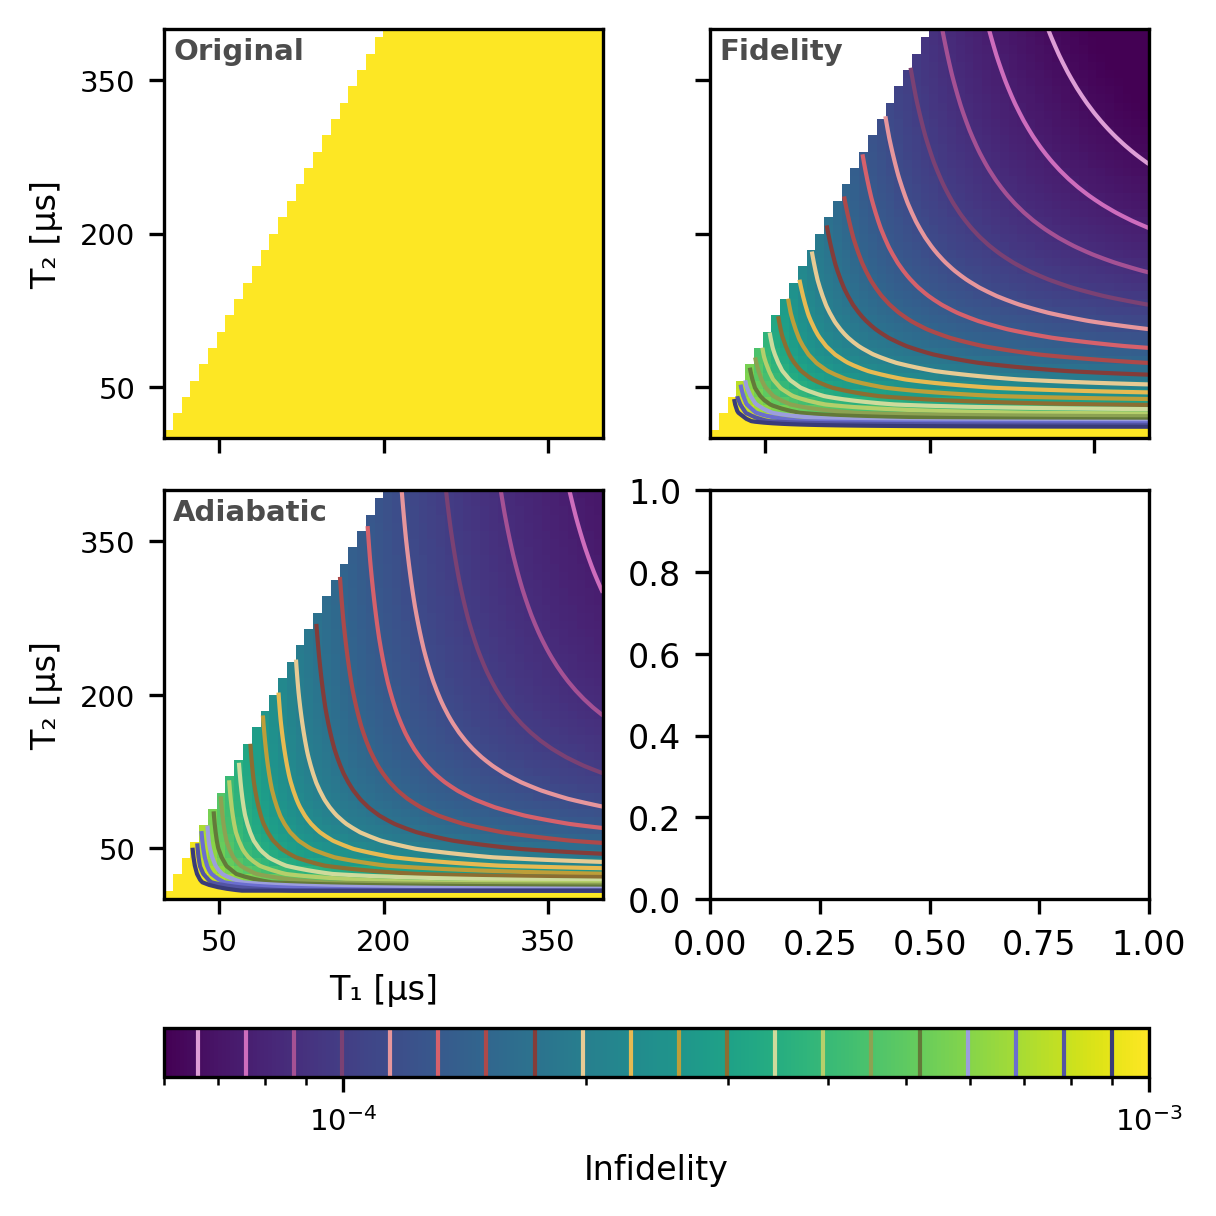

In [26]:
EPS_T = 6e-5
VMAX_T = 1e-3

# 1) define six log‑spaced contour levels
levels = np.logspace(np.log10(1.1*EPS_T), np.log10(0.9*VMAX_T), num=20)

# 2) pick six distinct colors
palette = plt.cm.tab20b.colors  # 20‑color qualitative palette
contour_colors = palette[::-1]

# 3) customize colormap for masked values
cmap = plt.cm.viridis.copy()
cmap.set_bad('white')

# 4) global settings
#VMAX_T = max(np.nanmax(v) for v in INF_T.values())
xticks = [50, 200, 350]
yticks = [50, 200, 350]

# 5) prepare meshgrid for contours
T1_grid, T2_grid = np.meshgrid(T1_vals, T2_vals)

# 6) create figure
fig, axs = plt.subplots(2, 2, figsize=(10*cm, 10*cm), constrained_layout=True)

titles = ['Original','Fidelity','Adiabatic']#,'Noise']
for (i, j), key in zip([(0,0),(0,1),(1,0),(1,1)], titles):
    ax = axs[i, j]
    data = INF_T[key]
    masked = np.ma.masked_invalid(data)

    # heatmap
    im = ax.imshow(masked,
                   origin='lower',
                   extent=[T1_vals[0], T1_vals[-1],
                           T2_vals[0], T2_vals[-1]],
                   aspect='auto',
                   norm=mcolors.LogNorm(vmin=EPS_T, vmax=VMAX_T),
                   cmap=cmap)

    # contours (common levels, different colors, no labels)
    cs = ax.contour(
        T1_grid, T2_grid, masked,
        levels=levels,
        colors=contour_colors,
        linewidths=1.0
    )

    # title inside
    ax.text(0.02, 0.98, key,
            transform=ax.transAxes,
            fontsize=7, fontweight='bold',
            va='top', ha='left', alpha=0.7)

    # ticks
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.tick_params(axis='x',
                   labelbottom=(i == 1),
                   labelsize=7,
                   direction='out')
    ax.tick_params(axis='y',
                   labelleft=(j == 0),
                   labelsize=7,
                   direction='out')

    # axis labels
    if i == 1:
        ax.set_xlabel('T₁ [µs]', fontsize=8)
    if j == 0:
        ax.set_ylabel('T₂ [µs]', fontsize=8)

# horizontal colorbar
cbar = fig.colorbar(im, ax=axs, orientation='horizontal',
                    pad=0.02, fraction=0.06)
cbar.set_label('Infidelity', fontsize=8)
cbar.ax.tick_params(labelsize=7)
cbar.add_lines(cs)
filename= f'T1_T2_heat.pdf'  
fig.savefig(os.path.join(figs_dir, filename), dpi=300, bbox_inches='tight')
plt.show()

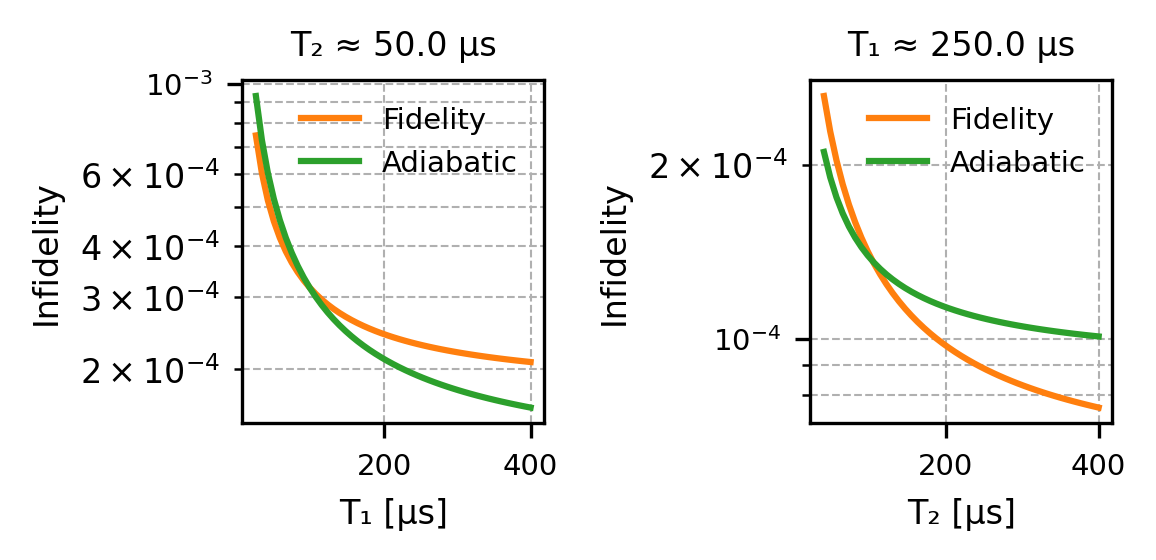

In [20]:
cm = 1/2.54  # inches per cm

# pick your slices
t2_target = 50.0  # µs
idx_t2 = np.argmin(np.abs(T2_vals - t2_target))

t1_target = 250.0  # µs
idx_t1 = np.argmin(np.abs(T1_vals - t1_target))

# create 1×2 grid
fig, axes = plt.subplots(1, 2, figsize=(10*cm, 5*cm))

# ─── Left: Infidelity vs T₁ (at T₂ ≈ t2_target) ───────────────────────────────
ax = axes[0]
for k, name in enumerate(PROT):
    if name != 'Original' and name != 'Ensemble':
        y = INF_T[name][idx_t2, :]
        ax.plot(T1_vals, y, label=name, color=COL[k], linewidth=1.5)

ax.set_yscale('log')
ax.set_xlabel('T₁ [µs]', fontsize=8)
ax.set_ylabel('Infidelity', fontsize=8)
ax.tick_params(labelsize=7, direction='out')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend(fontsize=7, frameon=False, handlelength=2)
ax.set_title(f"T₂ ≈ {t2_target} µs", fontsize=8)

# ─── Right: Infidelity vs T₂ (at T₁ ≈ t1_target) ────────────────────────────────
ax = axes[1]
for k, name in enumerate(PROT):
    if name != 'Original' and name != 'Ensemble':
        y = INF_T[name][:, idx_t1]
        ax.plot(T2_vals[5:], y[5:], label=name, color=COL[k], linewidth=1.5)

ax.set_yscale('log')
ax.set_xlabel('T₂ [µs]', fontsize=8)
ax.set_ylabel('Infidelity', fontsize=8)
ax.tick_params(labelsize=7, direction='out')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend(fontsize=7, frameon=False, handlelength=2)
ax.set_title(f"T₁ ≈ {t1_target} µs", fontsize=8)

plt.tight_layout()
filename= f'T1_T2_inf.pdf'  
fig.savefig(os.path.join(figs_dir, filename), dpi=300, bbox_inches='tight')
plt.show()


<a id="inf-area-doppler"></a>
## 9. Infidelity Maps (Area vs Doppler)  
Plot infidelity as a function of pulse area and Doppler shift for each optimization protocol, showing robustness to parameter variations.  


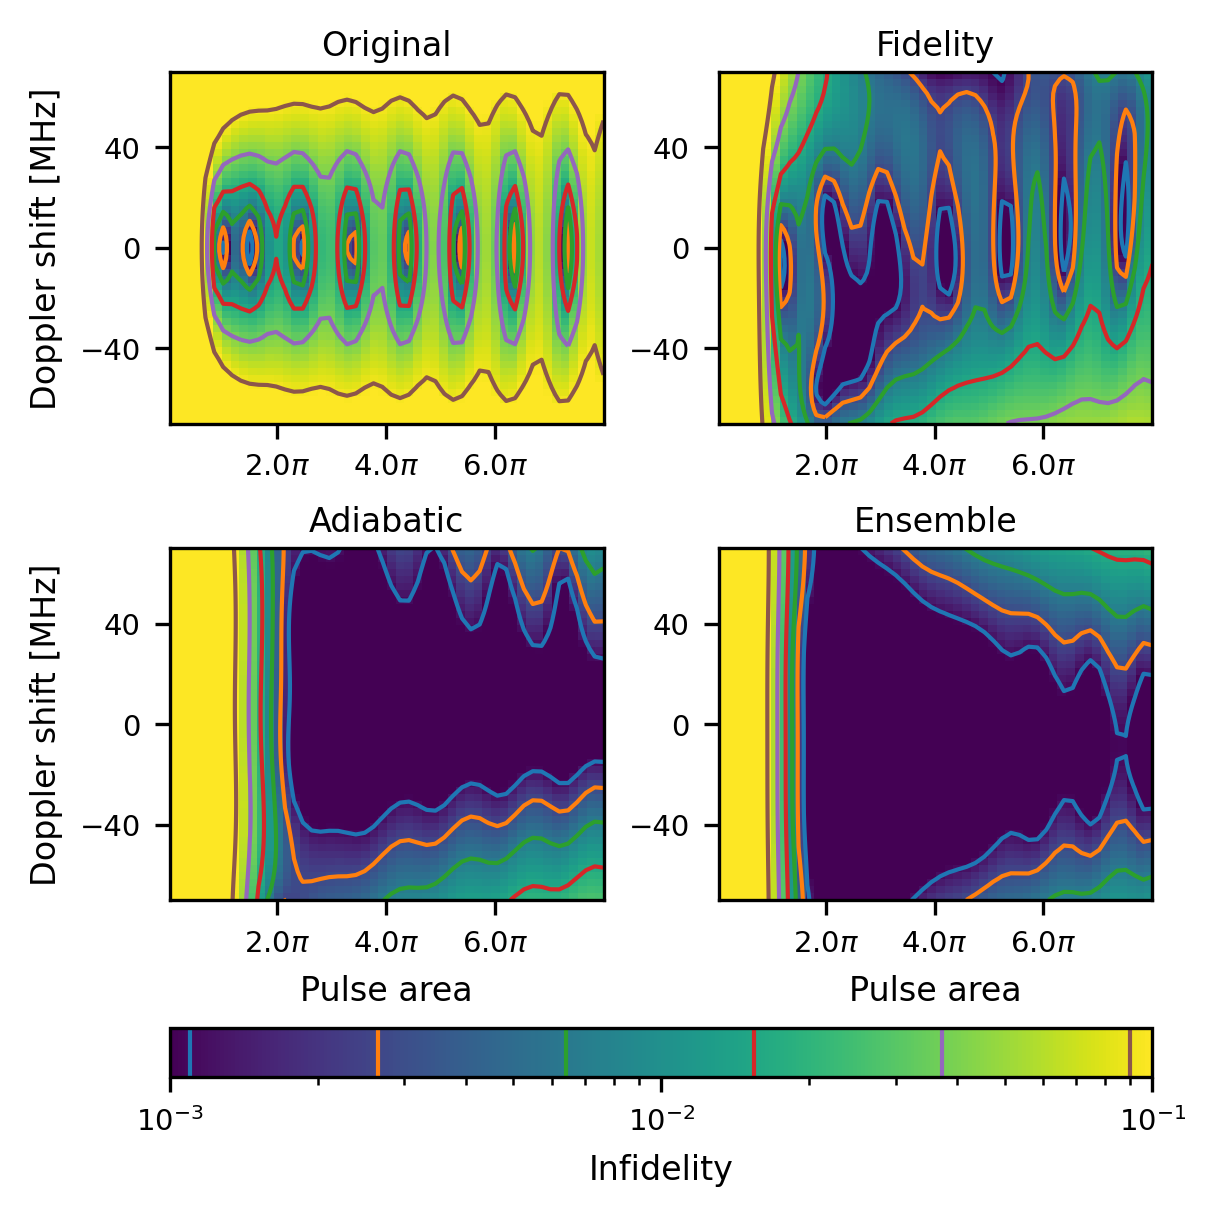

In [21]:
EPS_AD = 1e-3
VMAX_AD = 1e-1

# 1) define six log‑spaced contour levels
levels = np.logspace(np.log10(1.1*EPS_AD), np.log10(0.9*VMAX_AD), num=6)

# 2) pick six distinct colors from a qualitative palette
palette = plt.cm.tab10.colors  # 10‐color cycle
colors  = palette[:]

# 3) draw the 2×2 grid of heatmaps + colored contours
fig, axs = plt.subplots(2, 2, figsize=(10*cm, 10*cm), constrained_layout=True)
titles      = list(PROT.keys())
tick_areas  = [0.5*AREA_TARGET, AREA_TARGET, 1.5*AREA_TARGET]
tick_labels = [r"$2.0\pi$", r"$4.0\pi$", r"$6.0\pi$"]

# we'll keep a reference to one of the QuadContourSets
cs = None
titles = ['Original','Fidelity','Adiabatic','Ensemble']
for (i, j), key in zip([(0,0),(0,1),(1,0),(1,1)], titles):
    ax   = axs[i, j]
    data = INF_AD[key]
    masked = np.ma.masked_invalid(data)

    # heatmap
    im = ax.imshow(masked,
                   origin='lower',
                   extent=[area_vals[0], area_vals[-1],
                           dopp_vals[0], dopp_vals[-1]],
                   aspect='auto',
                   norm=mcolors.LogNorm(vmin=EPS_AD, vmax=VMAX_AD),
                   cmap=cmap)

    # draw each level in its own color
    cs = ax.contour(
        A_grid, D_grid, data,
        levels=levels,
        colors=colors,
        linewidths=1.0
    )

    # axes styling
    ax.set_title(key, fontsize=8, pad=4)
    ax.set_xticks(tick_areas)
    ax.set_xticklabels(tick_labels)
    if i == 1:
        ax.set_xlabel('Pulse area', fontsize=8)
    ax.set_yticks([-40, 0, 40])
    if j == 0:
        ax.set_ylabel('Doppler shift [MHz]', fontsize=8)
    ax.tick_params(labelsize=7, direction='out')

# 4) shared colorbar with contour‐line ticks
cbar = fig.colorbar(im, ax=axs, orientation='horizontal',
                    pad=0.02, fraction=0.06)
cbar.set_label('Infidelity', fontsize=8)
cbar.ax.tick_params(labelsize=7)

# add the colored contour‐level markers on the colorbar
cbar.add_lines(cs)
filename= f'pulse_area_dopp_inf.pdf'  
fig.savefig(os.path.join(figs_dir, filename), dpi=300, bbox_inches='tight')
plt.show()


<a id="pulses-bloch"></a>
## 10. Pulse Envelopes & Bloch Spheres  
Visualize the optimized pulse shapes (Ω & Δ) and compare the final Bloch vectors against the ground‐state trajectory.  


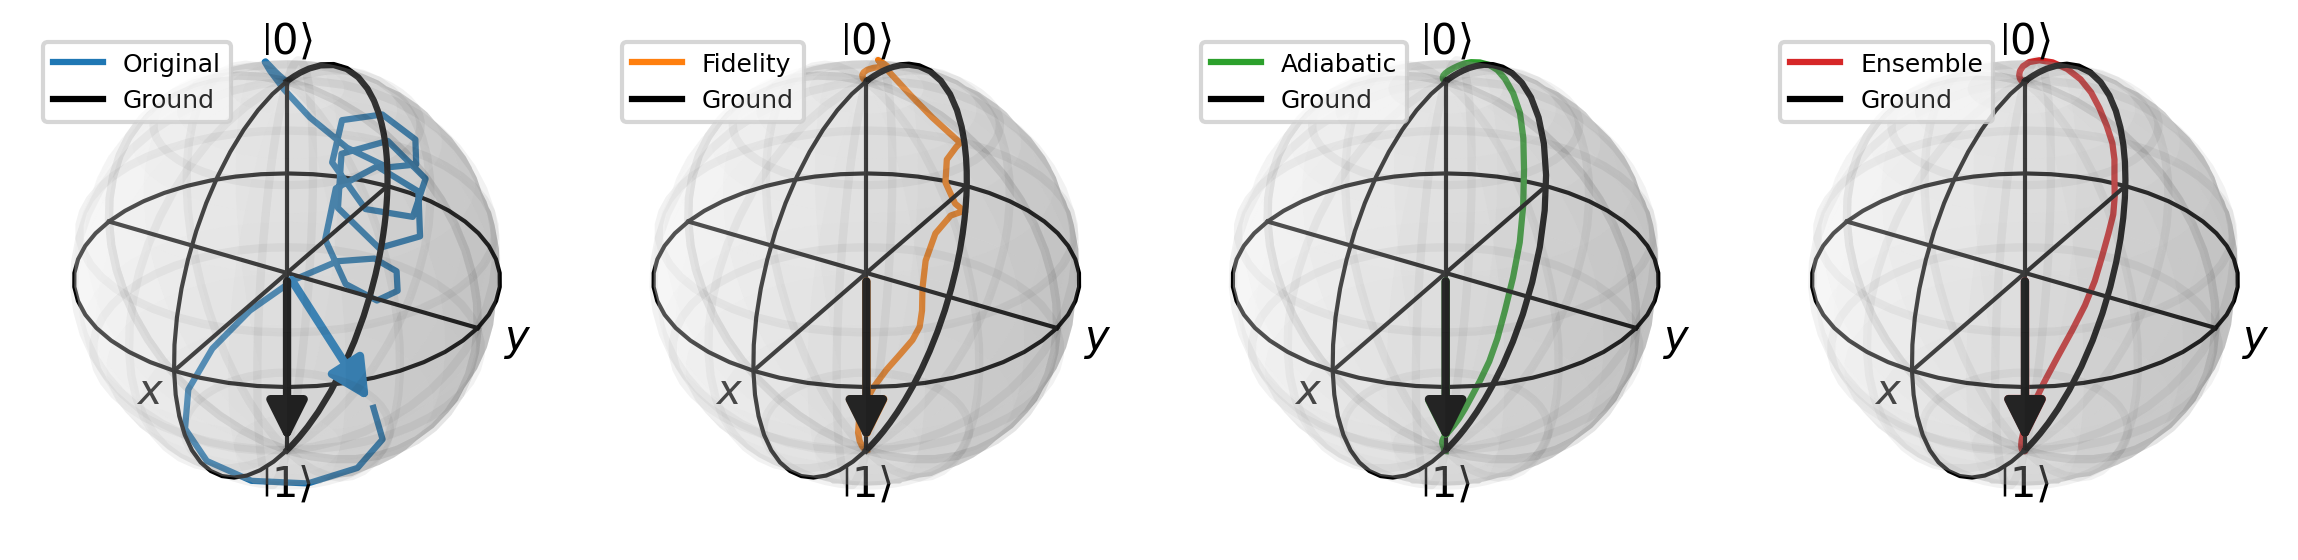

In [ ]:
from qutip import expect
from qutip import *

# Calculate expectation values from state trajectories
sx = sigmax()
sy = sigmay()
sz = sigmaz()

EX = {}
EY = {}
EZ = {}
GEX = {}
GEY = {}
GEZ = {}

# Calculate expectation values for each protocol
for name in PROT:
    # System trajectory
    EX[name] = [expect(sx, state) for state in STATE[name]]
    EY[name] = [expect(sy, state) for state in STATE[name]]
    EZ[name] = [expect(sz, state) for state in STATE[name]]
    
    # Ground state trajectory (assuming you have a function to calculate ground states)
    gs_traj = [inst_ground(t, PROT[name]) for t in tlist]
    GEX[name] = [expect(sx, state) for state in gs_traj]
    GEY[name] = [expect(sy, state) for state in gs_traj]
    GEZ[name] = [expect(sz, state) for state in gs_traj]

# Function to plot Bloch-sphere subplots: one for each protocol vs its ground state, with correct colors
def plot_bloch_subplots(EX, EY, EZ, GEX, GEY, GEZ, PROT, COL,
                        per_size_cm=5,
                        font_size=10,
                        vector_width=2,
                        line_width=1.5,
                        sphere_alpha=0.2,
                        frame_color='k',
                        sphere_color='#f0f0f0',
                        ground_col='black',
                        legend_loc='upper right',
                        save_path=None):
    """
    EX, EY, EZ : dict of arrays for system trajectories
    GEX, GEY, GEZ : dict of arrays for ground-state trajectories
    PROT : dict of protocol data (keys are protocol names)
    COL : list of colors corresponding to PROT keys in insertion order
    """
    names = list(PROT.keys())  # ordered protocol names

    # convert cm to inches
    cm2inch = 0.393701
    per = per_size_cm * cm2inch

    # create figure and axes
    n = len(names)
    fig, axes = plt.subplots(1, n, figsize=(per * n, per), subplot_kw={'projection': '3d'})
    if n == 1:
        axes = [axes]

    for i, ax in enumerate(axes):
        name = names[i]
        col = COL[i]

        bloch = Bloch(fig=fig, axes=ax)
        bloch.fig.patch.set_facecolor('white')
        bloch.font_size    = font_size
        bloch.frame_color  = frame_color
        bloch.frame_alpha  = 0.05
        bloch.frame_width  = 1
        bloch.view         = [-70, 20]
        bloch.sphere_color = sphere_color
        bloch.sphere_alpha = sphere_alpha
        bloch.vector_width = vector_width

        # set color/style lists for two datasets: [system, ground]
        line_colors   = [col, ground_col]
        point_colors  = [col, ground_col]
        vector_colors = [col, ground_col]
        line_styles   = ['-', '--']

        bloch.line_color   = line_colors
        bloch.point_color  = point_colors
        bloch.vector_color = vector_colors
        bloch.line_style   = line_styles

        # add points (trajectories)
        pts_sys = np.vstack((EX[name], EY[name], EZ[name]))
        pts_gnd = np.vstack((GEX[name], GEY[name], GEZ[name]))
        bloch.add_points(pts_sys, meth='l')
        bloch.add_points(pts_gnd, meth='l')

        # add final vectors: system then ground
        vec_sys = [EX[name][-1], EY[name][-1], EZ[name][-1]]
        vec_gnd = [GEX[name][-1], GEY[name][-1], GEZ[name][-1]]
        bloch.add_vectors([vec_sys, vec_gnd])

        bloch.make_sphere()

        # adjust line widths
        for line in ax.lines:
            if line.get_alpha() == 1.0:
                line.set_linewidth(line_width)

        # legend
        handles = [
            Line2D([0], [0], color=col,        lw=line_width, linestyle='-'),
            Line2D([0], [0], color=ground_col, lw=line_width, linestyle='-')
        ]
        labels = [name, 'Ground']
        ax.legend(handles, labels, loc=legend_loc, fontsize=font_size * 0.6)

    plt.tight_layout()
    if save_path:
        fig.savefig(os.path.join(figs_dir, save_path), format='pdf', dpi=300, bbox_inches='tight')
    plt.show()

# Example usage:

plot_bloch_subplots(EX, EY, EZ, GEX, GEY, GEZ, PROT, COL, per_size_cm=5, legend_loc='upper left', save_path='bloch_subplots.pdf')


/tmp/ipykernel_946130/1336258302.py:68: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(OMEGA[k], tlist) / np.pi
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

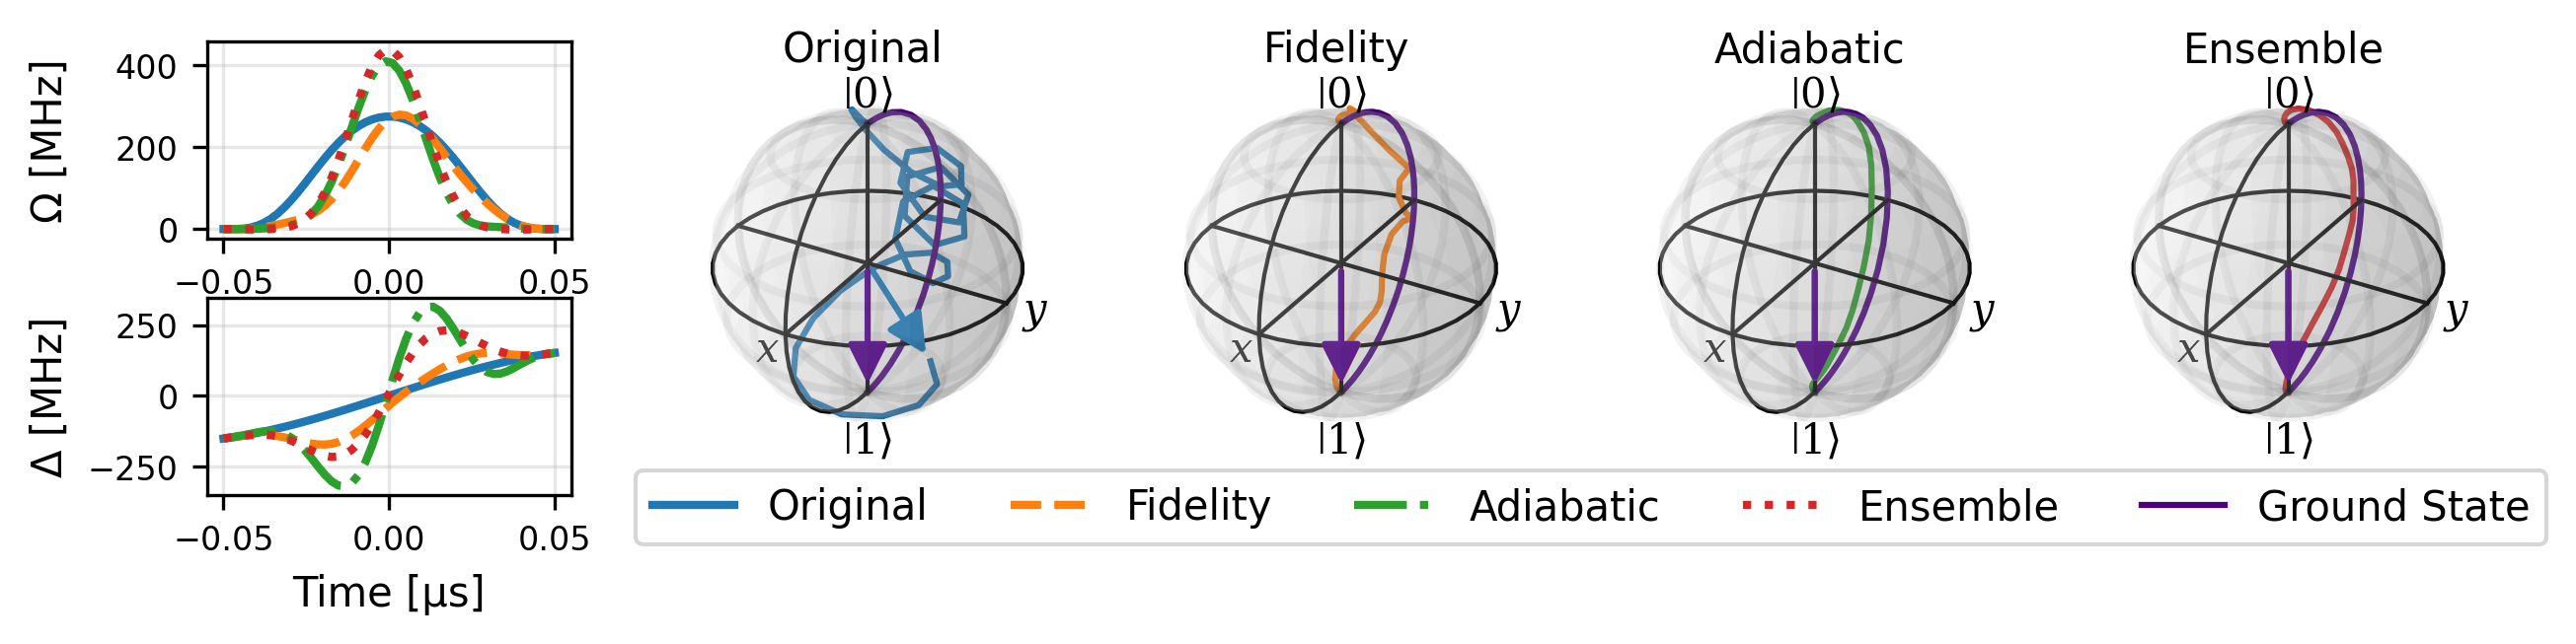

In [ ]:
# Combined function: Pulse envelopes + Bloch spheres in one figure
# Pulses and detunings axes each take half the height of the figure (spheres)
def plot_pulses_and_bloch(EX, EY, EZ, GEX, GEY, GEZ,
                          PROT, COL,
                          OMEGA, DELTA, tlist,
                          per_size_cm=5,
                          font_size=10,
                          vector_width=1.5,
                          line_width=1.5,
                          sphere_alpha=0.2,
                          frame_color='k',
                          sphere_color='#f0f0f0',
                          ground_col='indigo',
                          legend_loc='upper left',
                          save_path=None):
    """
    Create a combined figure with pulse envelopes & detunings on the left,
    followed by one Bloch sphere subplot per protocol comparing system vs ground.
    Pulses and detunings each occupy half the height of the figure (spheres).

    Parameters:
      EX, EY, EZ       : dict of arrays, system trajectories for each protocol
      GEX, GEY, GEZ    : dict of arrays, ground-state trajectories for each protocol
      PROT             : dict whose keys are protocol names in desired order
      COL              : list of colors matching PROT keys
      OMEGA, DELTA     : dicts of pulse envelopes and detunings for each protocol
      tlist            : time array for OMEGA/DELTA
      per_size_cm      : size in cm of each Bloch sphere subplot (width) and fig height
      font_size        : base font size
      vector_width     : width of Bloch vectors
      line_width       : width of trajectory lines
      sphere_alpha     : transparency of Bloch sphere surface
      frame_color      : color of Bloch sphere frame
      sphere_color     : sphere face color
      ground_col       : color for ground-state trajectory
      legend_loc       : legend location for pulse plot
      save_path        : if provided, path to save PDF
    """


    # text in Times New Roman
    mpl.rc('font',      family='serif', serif=['Times New Roman'])
    # math “Roman” letters (a, b, etc) taken from Times,
    # but symbols (|, ⟩, etc) from a font that actually has them
    mpl.rcParams['mathtext.fontset'] = 'dejavuserif'    # or 'stix'
    mpl.rcParams['mathtext.rm']      = 'Times New Roman'
    mpl.rcParams['mathtext.it']      = 'Times New Roman:italic'
    mpl.rcParams['mathtext.bf']      = 'Times New Roman:bold'

    # Ordered protocol names
    names = list(PROT.keys())
    n = len(names)
    # convert cm to inches
    cm2inch = 0.393701
    # each sphere subplot width = per cm, fig height = per cm
    per = per_size_cm * cm2inch
    # create figure: width = (n+1)*per, height = per
    fig = plt.figure(figsize=(per * (n + 1), per))
    # grid: 2 rows, n+1 cols; height_ratios give half-height for pulses/detuning, spheres span both rows
    gs = gridspec.GridSpec(2, n + 1, figure=fig,
                           width_ratios=[1] + [1] * n,
                           height_ratios=[1, 1],
                           wspace=0.3, hspace=0.3)

    # Pulse envelopes (row0,col0)
    ax_pulse = fig.add_subplot(gs[0, 0])
    for idx, k in enumerate(names):
        area = np.trapezoid(OMEGA[k], tlist) / np.pi
        ax_pulse.plot(tlist, OMEGA[k], color=COL[idx],
                      ls=['-', '--', '-.', ':',':'][idx],
                      label=f"{k}")
    ax_pulse.set_ylabel(r'Ω [MHz]',loc=None)

    ax_pulse.grid(alpha=0.3)

    # Detuning (row1,col0)
    ax_det = fig.add_subplot(gs[1, 0], sharex=ax_pulse)
    for idx, k in enumerate(names):
        ax_det.plot(tlist, DELTA[k], color=COL[idx],
                    ls=['-', '--', '-.', ':', ':'][idx])
    ax_det.set_ylabel(r'Δ [MHz]')
    ax_det.set_xlabel('Time [µs]')
    ax_det.grid(alpha=0.3)
    fig.align_ylabels()
    # Bloch spheres: each spans both rows
    for i, name in enumerate(names):
        ax = fig.add_subplot(gs[:, i + 1], projection='3d')
        bloch = Bloch(fig=fig, axes=ax)
        bloch.fig.patch.set_facecolor('white')
        bloch.font_size    = font_size
        bloch.frame_color  = frame_color
        bloch.frame_alpha  = 0.05
        bloch.frame_width  = 1
        bloch.view         = [-70, 20]
        bloch.sphere_color = sphere_color
        bloch.sphere_alpha = sphere_alpha
        bloch.vector_width = vector_width
        bloch.zlpos        = [1.2, -1.4]
        # colors and styles for system vs ground
        line_colors   = [COL[i], ground_col]
        point_colors  = [COL[i], ground_col]
        vector_colors = [COL[i], ground_col]
        line_styles   = ['-', '-']
        bloch.line_color   = line_colors
        bloch.point_color  = point_colors
        bloch.vector_color = vector_colors
        bloch.line_style   = line_styles

        # add trajectories
        pts_sys = np.vstack((EX[name], EY[name], EZ[name]))
        pts_gnd = np.vstack((GEX[name], GEY[name], GEZ[name]))
        bloch.add_points(pts_sys, meth='l')
        bloch.add_points(pts_gnd, meth='l')
        # add final vectors
        vec_sys = [EX[name][-1], EY[name][-1], EZ[name][-1]]
        vec_gnd = [GEX[name][-1], GEY[name][-1], GEZ[name][-1]]
        bloch.add_vectors([vec_sys, vec_gnd])

        bloch.make_sphere()
        for line in ax.lines:
            if line.get_alpha() == 1.0:
                line.set_linewidth(line_width)
        ax.set_title(name, fontsize=font_size)

    

    # 1. pull handles & labels from the pulse-plot
    ground_handle = Line2D([0], [0],
                       color=ground_col,
                       lw=line_width,
                       ls='-')
    handles, labels = ax_pulse.get_legend_handles_labels()
    handles.append(ground_handle)
    labels.append('Ground State')
    # 2. add a single-row legend below the Bloch spheres
    
    fig.legend(
        handles, labels,
        loc='lower center',
        bbox_to_anchor=(0.6, -0.02),   # adjust vertical placement
        ncol=len(names)+1,
        frameon=True,
        fontsize=font_size ,
        columnspacing= 2
    )

    # 3. make room at the bottom so it isn’t clipped
    fig.subplots_adjust(bottom=0.1)
    if save_path:
        fig.savefig(os.path.join(figs_dir, save_path), format='pdf', dpi=300, bbox_inches='tight')
    plt.show()

    
plot_pulses_and_bloch(EX, EY, EZ, GEX, GEY, GEZ, PROT, COL, OMEGA, DELTA, tlist, per_size_cm=5, save_path='combined_figure.pdf')

In [37]:
save_run(OMEGA, DELTA, seed=SEED, algo_settings={"BUDGET": BUDGET})


✅ Saved pulses, detunings, 0 figures, and a manifest to:
   /home/yehon/projects/grape-crab-qoc/notebooks/results/CMA-ES



In [33]:
# %% Load pulse data
import pathlib, numpy as np

# point this to wherever your .npy pulse files live
pulse_dir = pathlib.Path(r"/home/yehon/projects/grape-crab-qoc/notebooks/results/2025‑11‑01_21‑17‑37/")

PROT = [ 'Original', 'Fidelity', 'Adiabatic', 'Ensemble']#'Noise', 'Ensemble' ]  # protocol names

# for each protocol name in PROT, load its omega & delta arrays
OMEGA = {name: np.load(pulse_dir / f"Omega_{name}.npy") for name in PROT}
DELTA = {name: np.load(pulse_dir / f"Delta_{name}.npy") for name in PROT}


In [35]:
import numpy as np
tau, Nt = 0.05, 50
tlist = np.linspace(-tau, tau, Nt)

# noise times (µs)
T1, T2 = 400.0, 100.0
Tphi = 1 / (1 / T2 - 1 / (2 * T1))


# optimisation settings
AREA_TARGET = 4 * np.pi
LAMBDA_PEN  = 1.0
N_MODES     = 5        # Fourier terms

BASE = {
    'A': 1.0, 'B': 3.0, 'C': 2.0,
    'a': 1.25*0.55, 'b': 0.25*0.55,
    'corr':  np.zeros(N_MODES),
    'dcorr': np.zeros(N_MODES),
}
print("Base parameters:", BASE)
normalization = 4*np.pi / (np.trapezoid([pulses(t, BASE)[0] for t in tlist], tlist))
BASE = {
    'A': 1.0 * normalization,
    'B': 3.0 * normalization,
    'C': 2.0 * normalization,
    'a': 1.25 * normalization ,
    'b': 0.25 * normalization ,
    'corr':  np.zeros(N_MODES),
    'dcorr': np.zeros(N_MODES),
}
print("Base parameters:", BASE)

Base parameters: {'A': 1.0, 'B': 3.0, 'C': 2.0, 'a': 0.6875, 'b': 0.1375, 'corr': array([0., 0., 0., 0., 0.]), 'dcorr': array([0., 0., 0., 0., 0.])}
Base parameters: {'A': np.float64(275.407144203266), 'B': np.float64(826.2214326097981), 'C': np.float64(550.814288406532), 'a': np.float64(344.2589302540825), 'b': np.float64(68.8517860508165), 'corr': array([0., 0., 0., 0., 0.]), 'dcorr': array([0., 0., 0., 0., 0.])}
